# Aufgabe 1 (5P)

## a)
Nutzen Sie vom Datensatz „pvtest.csv“ die Werte 'Edaily','Dci','Dcp','Dcu','Temp1','hour‘ und erstellen Sie einen DataFrame
als Zeitreihe, ähnlich wie unten abgebildet. Auf Grundlage dieser Daten soll der Energieertrag Dcp immer in 5 Minuten in
der Zukunft prognostiziert werden. (0.5P)

<img src='images/1a.png' width=400>

In [19]:
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from keras import Sequential
from keras.src.callbacks import EarlyStopping, ModelCheckpoint
from keras.src.layers import LSTM, Bidirectional, Dropout, Dense
from matplotlib.pyplot import legend
from sklearn.metrics import mean_absolute_error
from keras.src.saving import load_model
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('pvtest.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%y %H:%M')
df.set_index('Time', inplace=True)

df = df[['Edaily', 'Dci', 'Dcp', 'Dcu', 'Temp1']]
df['hour'] = df.index.hour

print(df.tail(15))
print(df.shape)

                     Edaily       Dci  Dcp  Dcu  Temp1  hour
Time                                                        
2021-01-26 16:25:00   3.108  0.192504  113  587   14.0    16
2021-01-26 16:30:00   3.122  0.111913   62  554   14.0    16
2021-01-26 16:35:00   3.130  0.053846   28  520   14.0    16
2021-01-26 16:40:00   3.137  0.041176   21  510   14.0    16
2021-01-26 16:45:00   3.141  0.024283   11  453   14.0    16
2021-01-26 16:50:00   3.144  0.000000    0  271   14.0    16
2021-01-26 16:55:00   3.145  0.000000    0  257   13.0    16
2021-01-26 17:00:00   3.145  0.000000    0  251   12.0    17
2021-01-26 17:05:00   3.145  0.000000    0  250   12.0    17
2021-01-26 17:10:00   3.145  0.000000    0   37    1.0    17
2021-01-26 17:15:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:20:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:25:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:35:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:40:00   3.

## b)
Teilen Sie die Daten sinnvoll in Lern-und Testdatensatz auf, so dass die zeitlichen Reihenfolgen bestehen bleiben ! (0.5P)

In [9]:
# manual split for test data
end_train = ceil(len(df) * 0.9)
df_train = df.iloc[:end_train]
df_test = df.iloc[end_train:]

X_train = df_train
X_test = df_test
y_train = df_train[['Dcp']]
y_test_raw  = df_test[['Dcp']]

print('Training attribute shape:', X_train.shape, 'Training label shape:', y_train.shape)
print('Test attribute shape:', X_test.shape, 'Test label shape:', y_test_raw.shape)

Training attribute shape: (3191, 6) Training label shape: (3191, 1)
Test attribute shape: (354, 6) Test label shape: (354, 1)


## c)
Standardisieren Sie die Daten mit dem Standardscaler und restrukturieren Sie die Zeitreihe in einzelne Datenfenster, so dass
Sie aus allen vorhandenen 6 Features aus den letzten drei Stunden immer jeweils den Energieertrag für die nächsten 5
Minuten vorhersagen können. (1,5P)

In [10]:
# scale data
scaler = StandardScaler()

# one scaler for attributes
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# one scaler for targets
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test_raw)

# create window and define target offset (horizon)
def restructure_data(x:pd.DataFrame, y:pd.DataFrame, window:int, horizon:int):
    x_, y_ = [], []
    idx_range = range(len(x) - (window + horizon))
    for i in idx_range:
        x_.append(x[i:i + window])
        y_.append(y[i + window + horizon])
    x_ = np.array(x_)
    y_ = np.array(y_)
    return x_, y_

X_train, y_train = restructure_data(X_train, y_train, window=36, horizon=1)
X_test, y_test = restructure_data(X_test, y_test, window=36, horizon=1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3154, 36, 6) (3154, 1) (317, 36, 6) (317, 1)


# d)
Definieren und kompilieren Sie jetzt ein passendes Modell in Keras, welches mind. eine LSTM-Layer nutzt und DropoutLayer einfügt, um „Überanpassung“ zu verhindern. (1P)

In [11]:
model = Sequential([
    Bidirectional(LSTM(units=16, return_sequences=True, dropout=0.2), input_shape=(36, 6)), # return_sequence=True returns the entire sequence instead of one vektor
    LSTM(units=32, dropout=0.2),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
model.summary()

C:\Users\aaron\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 36, 32)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,353 (48.25 KB)

 Trainable params: 12,353 (48.25 KB)

 Non-trainable params: 0 (0.00 B)

## e)
Trainieren Sie das Modell mit allen Lerndaten über mind. 100 Epochen, nutzen Sie ggf. auch callbacks, um den Lernprozess
zu verkürzen. Verbessern Sie Ihr Training und Ihre Modellarchitektur so lange, bis Sie einen Mean absolute Error von mind.
50 erzielen! (1P)

In [12]:
early = EarlyStopping(monitor='val_loss', patience=10)
check = ModelCheckpoint(filepath='consumption_power_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_test, y_test), callbacks=[early, check], verbose=1)

model = load_model('consumption_power_model.keras')
y_true = y_test_raw[36+1:] # unscaled data

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred) # reverse the scaling process

mae_model = mean_absolute_error(y_true, y_pred_inv)
print('mae, model predictions {:.3f}'.format(mae_model))


Epoch 1/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5026 - mae: 0.3898 - val_loss: 0.0536 - val_mae: 0.1669
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2816 - mae: 0.2951 - val_loss: 0.0300 - val_mae: 0.1234
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2500 - mae: 0.2663 - val_loss: 0.0299 - val_mae: 0.1187
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2181 - mae: 0.2511 - val_loss: 0.0346 - val_mae: 0.1261
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2246 - mae: 0.2502 - val_loss: 0.0309 - val_mae: 0.1224
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2127 - mae: 0.2429 - val_loss: 0.0302 - val_mae: 0.1261
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1879 - mae: 0.2302 - val_loss: 0.0323 - val_mae: 0.1303
Epoch 8/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1709 - mae: 0.2197 - val_loss: 0.0297 - val_mae: 0.1213
Epoch 9/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - lo

# f)
Visualisieren Sie Ihre Prognoseergebnisse, so ähnlich wie unten angegeben im Vergleich gemessener Daten mit
prognostizierten Werten! (0.5P)

<img src="images/1f.png" width=900>

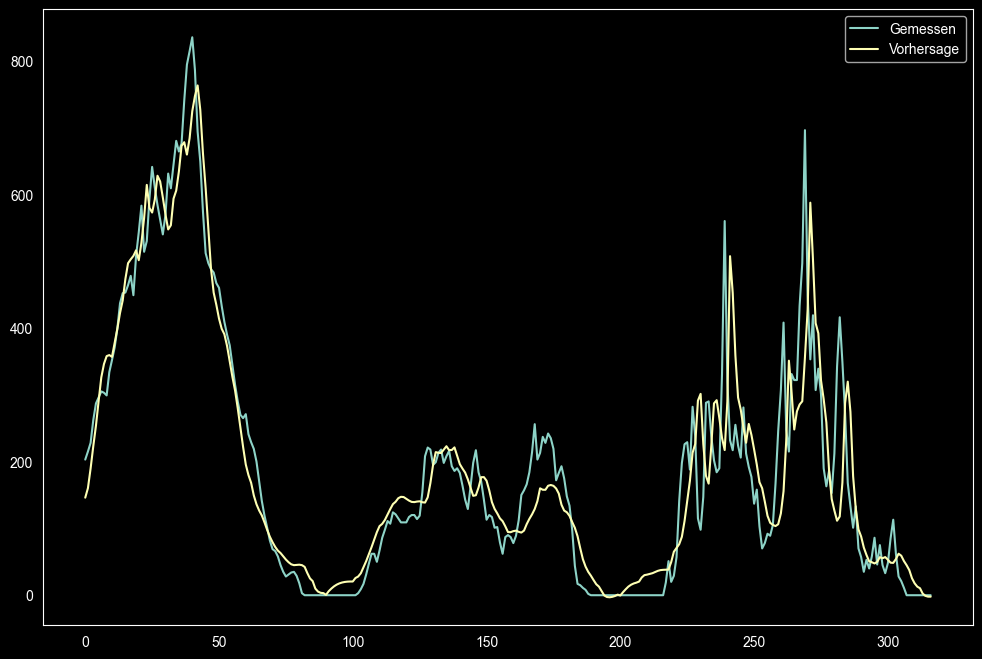

In [13]:
raw_data = y_true.Dcp.values
pred_data = y_pred_inv

plt.figure(figsize=figsize(12, 8))
plt.plot(raw_data, label='Gemessen')
plt.plot(pred_data, label='Vorhersage')
plt.legend()
plt.grid(False)